<a href="https://colab.research.google.com/github/annajliu110101/Uber-Driver-Pay-Algorithm/blob/main/notebooks/Exploaration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/annajliu110101/Uber-Driver-Pay-Algorithm.git
!cd /content/Uber-Driver-Pay-Algorithm/

fatal: destination path 'Uber-Driver-Pay-Algorithm' already exists and is not an empty directory.


In [3]:
!pip install meteostat
!pip install pyarrow
!pip install polars

In [4]:
# Uber Fare Prediction – Milestone 2 Exploration
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import table
import matplotlib.pyplot as plt


from datetime import datetime
from meteostat import Stations, Daily
from pathlib import Path

import pyarrow.dataset as ds
import pyarrow as pa
from pyarrow.dataset import Dataset, Scanner
import pyarrow.parquet as pq

import polars as pl

from geopy.geocoders import Nominatim



"hello"

'hello'

In [5]:
df = ds.dataset('/content/Uber-Driver-Pay-Algorithm/data/uber_nyc_forhire_2025/', ignore_prefixes = ['.DS_Store', 'data_dictionary', 'taxi_zone'], format = 'parquet')
scanner = df.scanner()


In [6]:
df = pq.read_pandas('/content/Uber-Driver-Pay-Algorithm/data/uber_nyc_forhire_2025/fhvhv_tripdata_2025-01.parquet')
df = df.to_pandas()

In [7]:
print(df.shape)
df.head()


(15356455, 17)


,request_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,cbd_congestion_fee
0,2025-01-01 00:28:07,2025-01-01 00:33:25,2025-01-01 00:54:24,148,211,1.32,1259,18.21,0.0,0.46,1.50,2.75,0.0,0.00,15.71,N,0.0
1,2025-01-01 00:28:22,2025-01-01 00:32:39,2025-01-01 01:20:33,132,181,13.43,2874,40.36,0.0,1.18,3.80,0.00,2.5,0.00,47.75,N,0.0
2,2025-01-01 00:27:13,2025-01-01 00:34:55,2025-01-01 00:39:19,76,76,0.82,264,12.24,0.0,0.34,1.08,0.00,0.0,0.00,12.20,N,0.0
3,2025-01-01 00:33:29,2025-01-01 00:46:19,2025-01-01 00:53:56,76,76,1.61,457,19.76,0.0,0.54,1.76,0.00,0.0,0.00,17.67,N,0.0
4,2025-01-01 00:34:43,2025-01-01 00:45:50,2025-01-01 01:20:23,112,89,9.66,2073,29.50,0.0,0.81,2.62,0.00,0.0,6.58,40.16,N,0.0


In [8]:
dataset = df.drop("shared_request_flag", axis=1)
correlation_matrix = dataset.corr()

<Axes: >

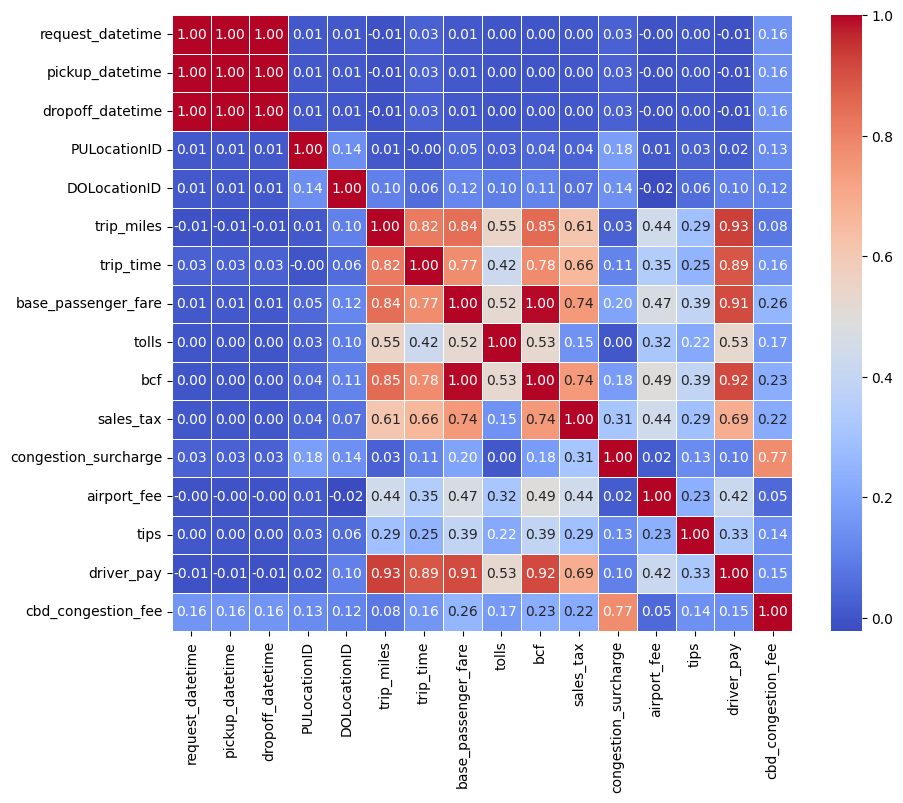

In [9]:
#Plotted a correlation matrix showing the influence of each attribute / column on each other

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

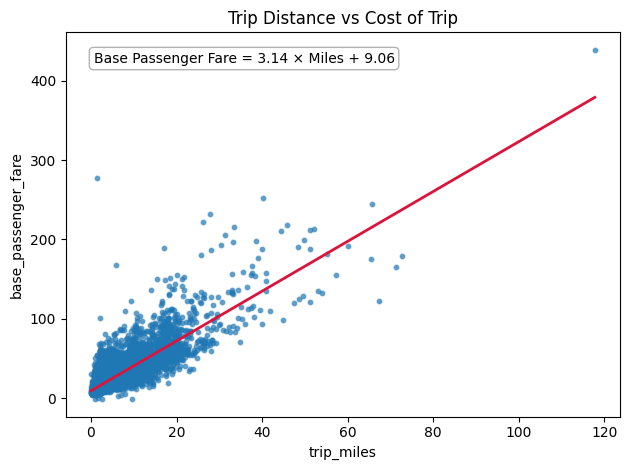

In [10]:
#Made a scatterplot of trip in miles vs base passenger fare to see how distance affects the cost of the ride

sample = (dataset[['trip_miles','base_passenger_fare']].dropna().sample(n=10_000, random_state=42))

sns.scatterplot(data=sample, x='trip_miles', y='base_passenger_fare', s=12, alpha=0.5)
plt.xlabel("Trip Distance (Miles)")
plt.ylabel("Base Passenger Fare (US Dollars)")
plt.title("Trip Distance vs Cost of Trip")

ax = sns.regplot(
    data=sample, x="trip_miles", y="base_passenger_fare",
    scatter_kws={"s":12, "alpha":0.4},
    line_kws={"color":"crimson", "lw":2},
    ci=None
)

x = sample["trip_miles"].to_numpy()
y = sample['base_passenger_fare'].to_numpy()
m, b = np.polyfit(x, y, 1)
r2 = 1 - ((y - (m*x + b))**2).sum() / ((y - y.mean())**2).sum()

ax.text(
    0.05, 0.95,
    f"Base Passenger Fare = {m:.2f} × Miles + {b:.2f}",
    transform=ax.transAxes, ha="left", va="top",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.7")
)

plt.tight_layout()
plt.show()

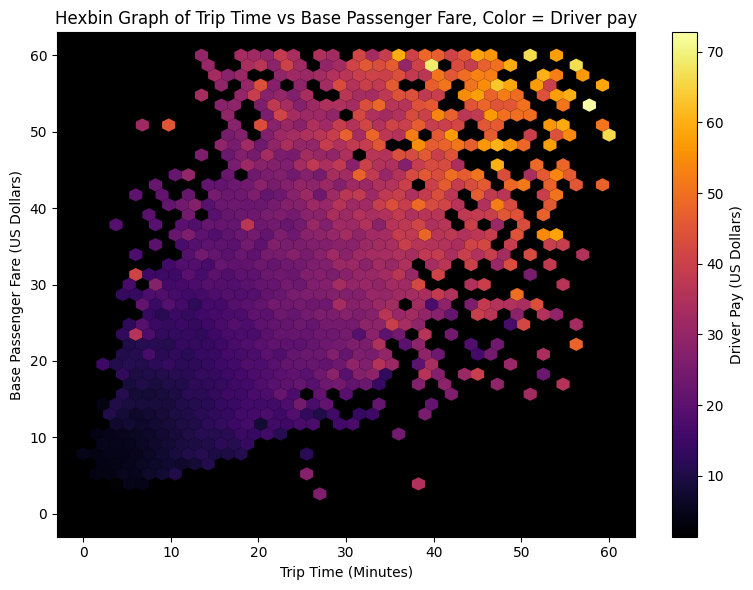

In [22]:
#Hexbin Graph showing Trip time plotted against Base passenger fare with the color being the driver pay.
#It seems as the trip time is greater than 40 mins, the driver gets paid more than half the base passenger fare

sample = (dataset[['trip_time','base_passenger_fare', 'driver_pay']].dropna().sample(n=10_000, random_state=42))
sample = sample[sample["base_passenger_fare"] > 0]

x = sample["trip_time"].to_numpy()
x = x / 60.0
y = sample["base_passenger_fare"].to_numpy()
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_facecolor("black")

hb = plt.hexbin(x, y, C = sample['driver_pay'], gridsize = 40, extent = [0, 60, 0, 60], cmap='inferno', linewidths = 0.0)
cbar = plt.colorbar(hb)
cbar.set_label("Driver Pay (US Dollars)")

ax.set_xlabel("Trip Time (Minutes)")
ax.set_ylabel("Base Passenger Fare (US Dollars)")
ax.set_title("Hexbin Graph of Trip Time vs Base Passenger Fare, Color = Driver pay")
plt.tight_layout()
plt.show()